In [3]:
import numpy as np
import nevopy as ne
import importlib
import matplotlib.cm as cm
import time
from IPython.display import Video

import ca_environment as caenv
import ca_agent as caag

In [4]:
importlib.reload(caenv)
importlib.reload(caag)

<module 'ca_agent' from '/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/ca_agent.py'>

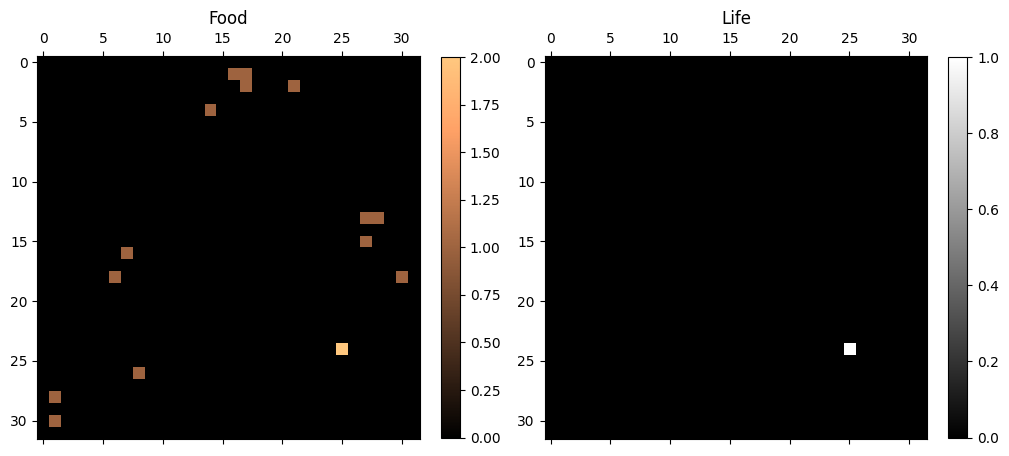

In [5]:
env = caenv.CAEnvironment()
env.gen_padded_food()
env.innoculate()
env.display()


In [6]:
ag = caag.CAAgent()
def lame_rules(chunk, env):
    return [1] * env.n_channels

ag.set_rule_func(lame_rules)

In [7]:
rag = caag.CAAgent()
def rand_rules(chunk, env):
    return np.random.random(env.n_channels)
rag.set_rule_func(rand_rules)

In [8]:
env.start_new_video(channels=(env.food_i, env.life_i, 2), cmaps = (cm.copper,cm.gray,cm.hot))
for _ in range(30):
    # ag.apply_to_env(env, log=True, vid_speed=3)
    rag.apply_to_env(env, log=True, vid_speed=5)

In [9]:
Video(env.gen_video())

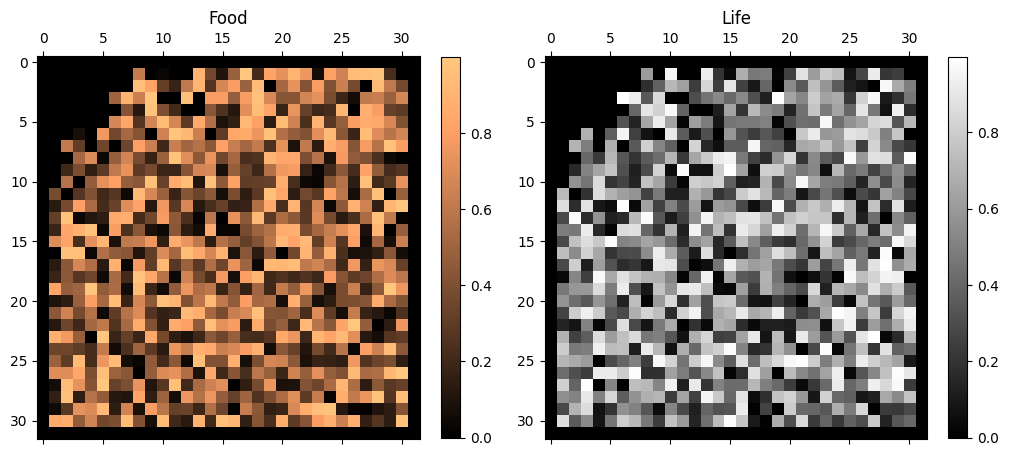

In [10]:
env.display()

In [11]:
from eval_env import load_tests

tenvs = load_tests()

In [12]:
tenv = tenvs['1']['2']


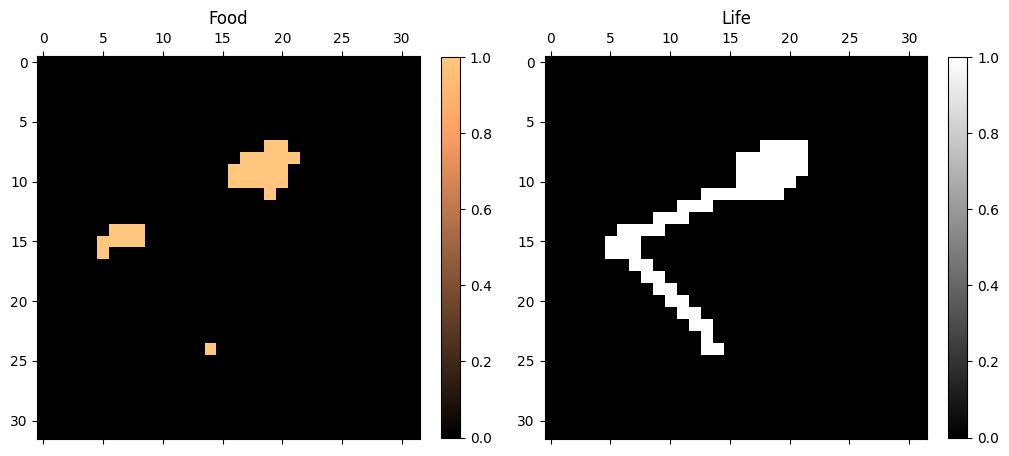

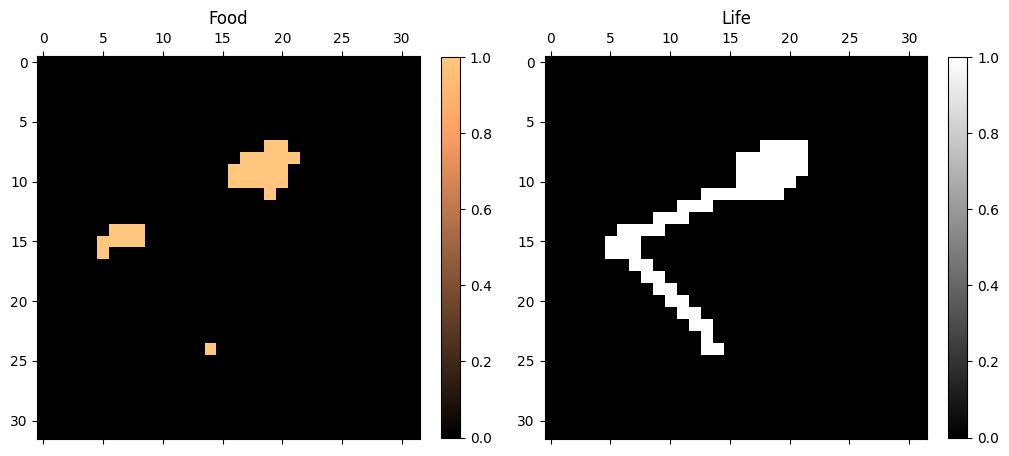

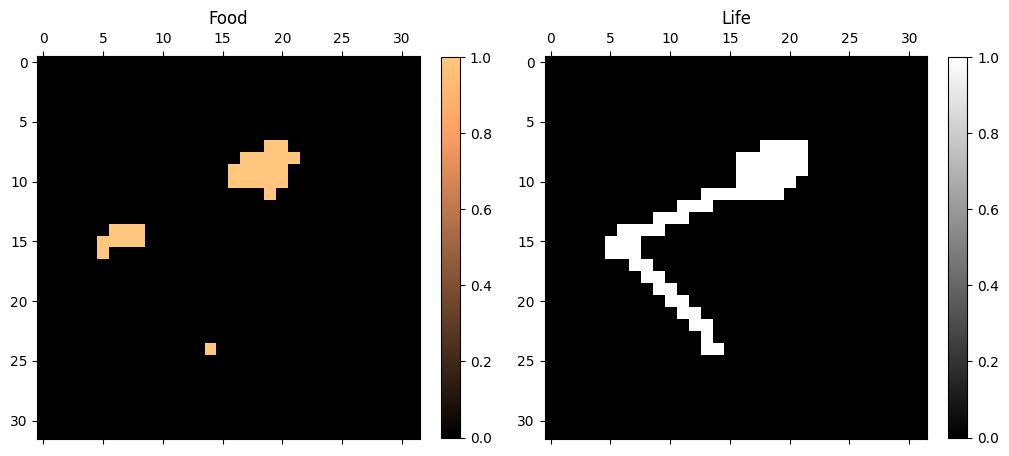

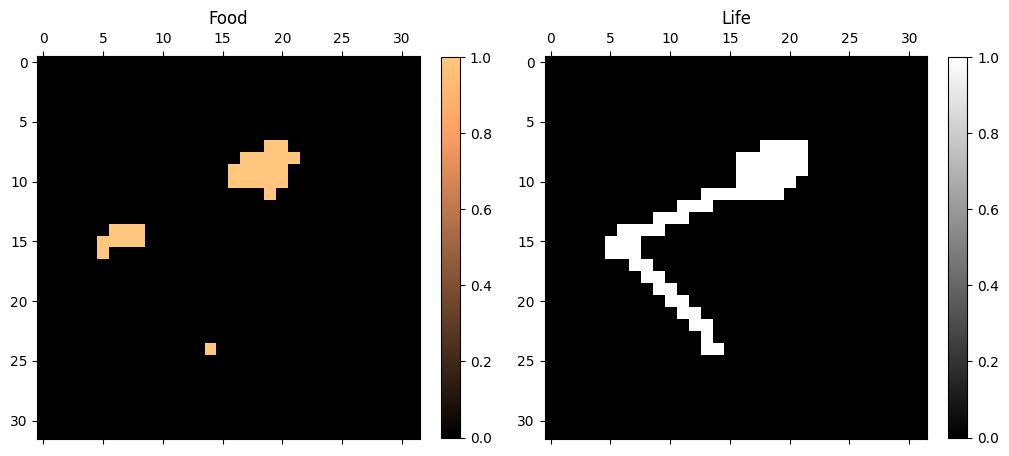

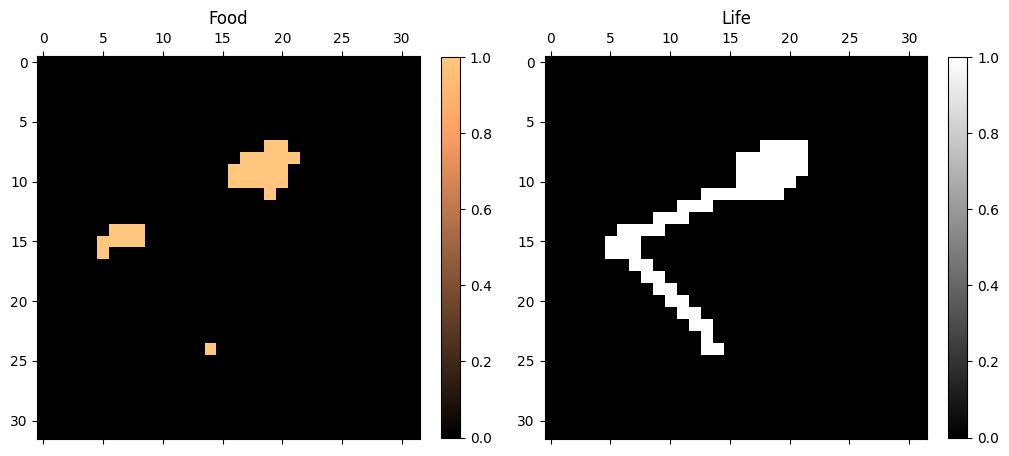

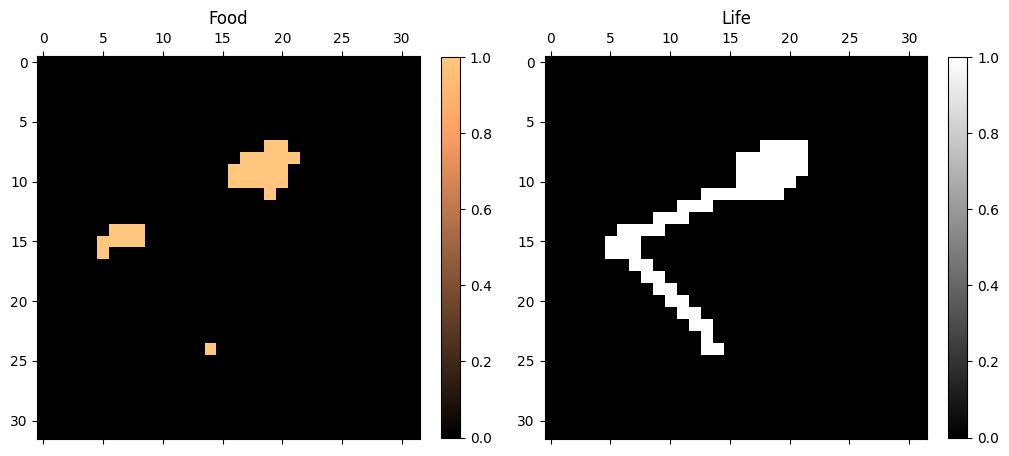

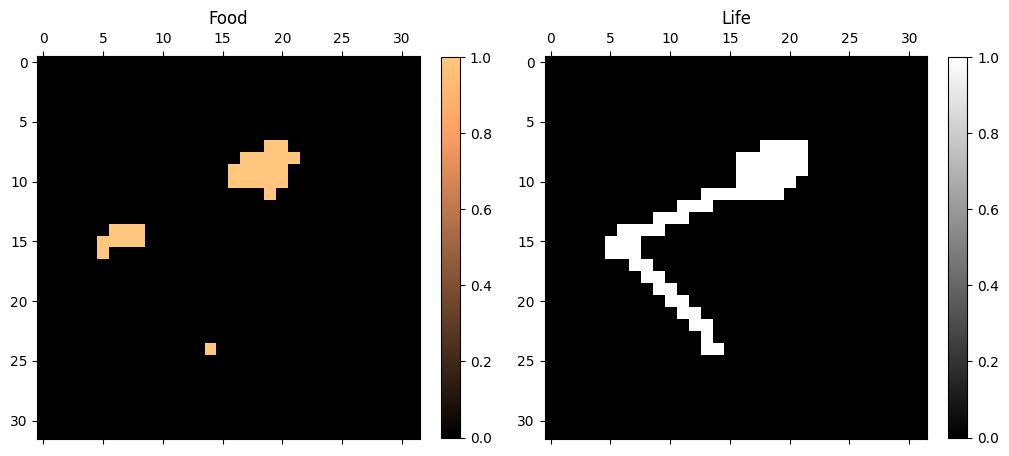

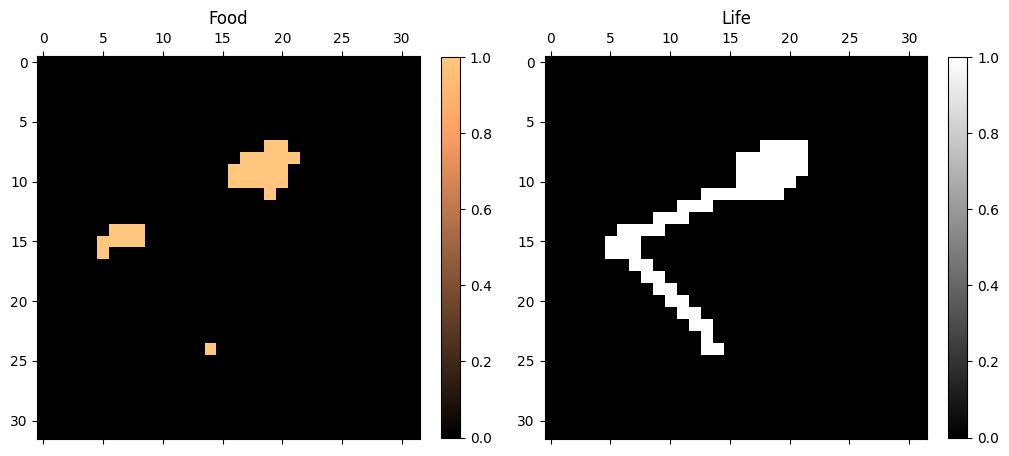

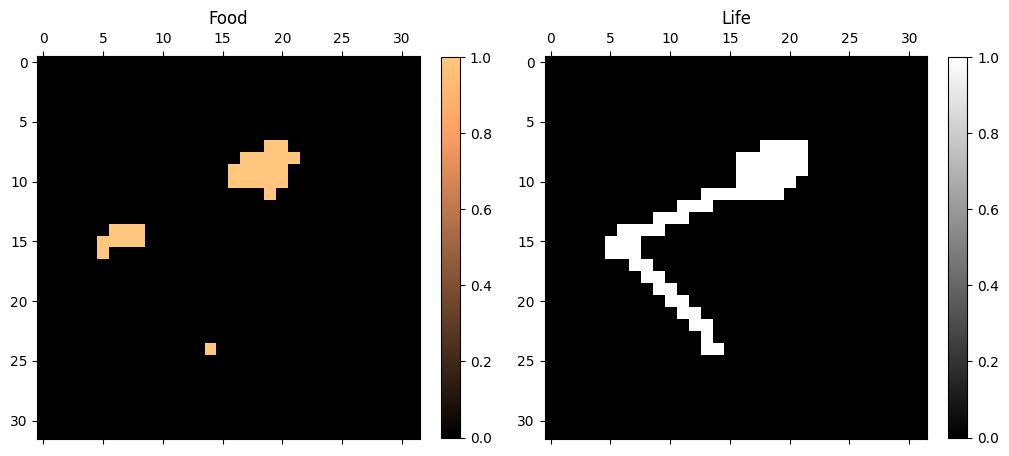

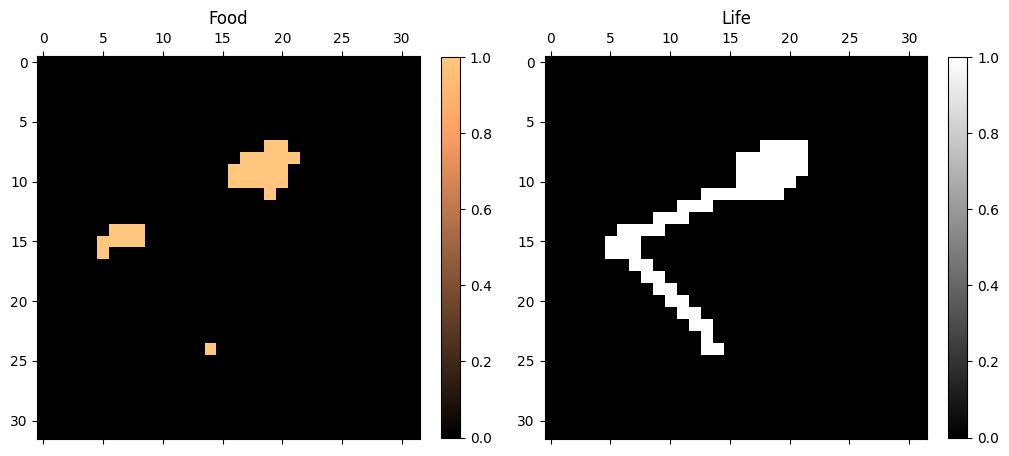

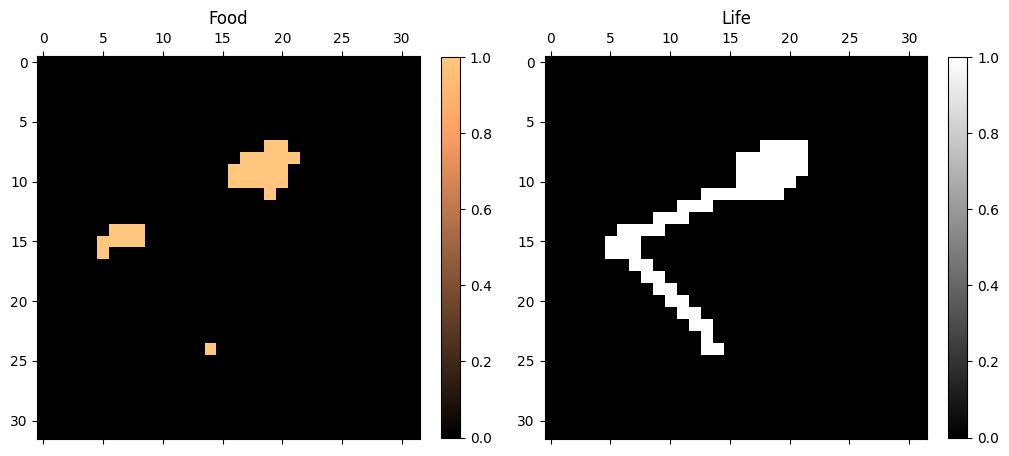

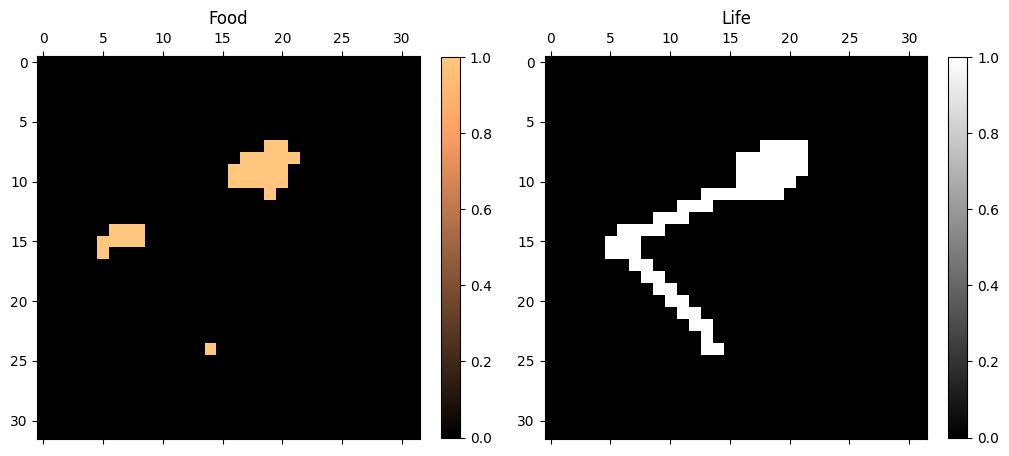

In [13]:
for fkey in tenvs.keys():
    for ekey in tenvs[fkey].keys():
        tenvs[fkey][ekey].display()

In [812]:
def random_walk(chunk, foveal, env):
    out = (np.random.random(2)*env.cutsize*2) - env.cutsize
    out = np.append(out,foveal,axis=0)
    out = np.append(out,np.zeros((env.n_hidden)), axis=0)
    return out

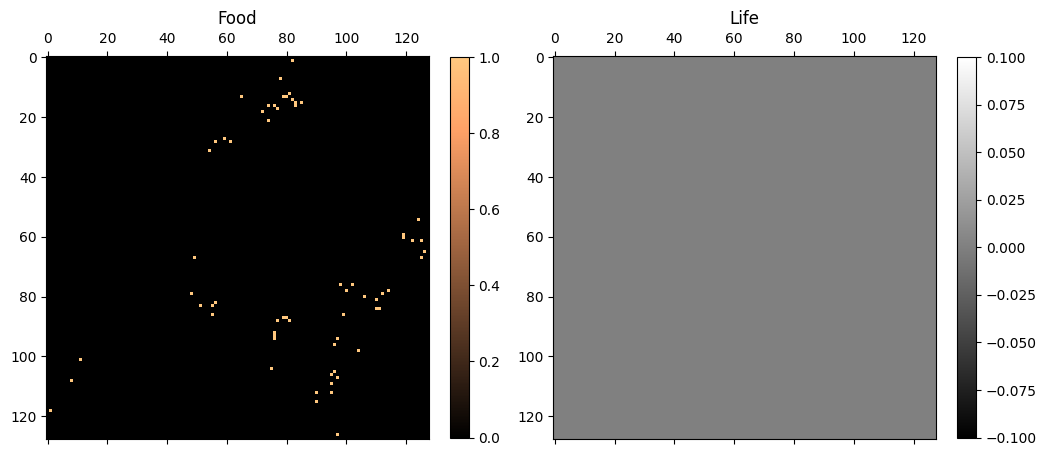

In [833]:
importlib.reload(caag)
importlib.reload(caenv)
wenv = caenv.CAEnvironment()
w_ragent = caag.CAAgent(kernel="moore")
w_ragent.set_walk_func(random_walk)
wenv.update_shape((w_ragent.n_spatial_chs + 1, 128, 128), n_hidden_chs=w_ragent.n_spatial_chs)

wenv.food_amt = 64
wenv.beta = 1
wenv.alpha = 0.7
wenv.gen_padded_food()
wenv.display()

0.0

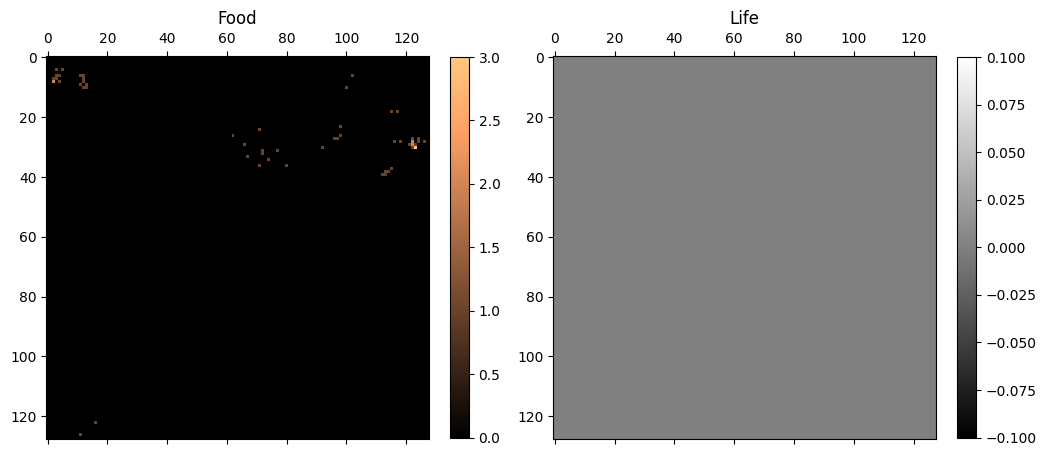

In [818]:
f = w_ragent.apply_walk_to_env(wenv, max_steps=1000)
wenv.display(channels=(0,1))
f


In [37]:
import time

time.time()

1667278044.0740821

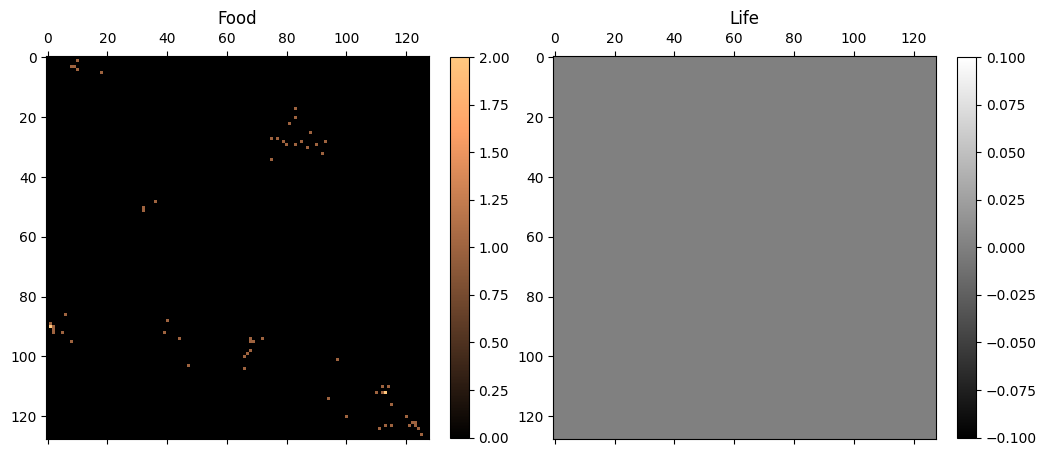

In [45]:
wenv = caenv.CAEnvironment()
wenv.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
wenv.food_amt = 64
wenv.beta = 1
wenv.alpha = 0.7
wenv.gen_padded_food()
wenv.display()

for i in range(100):
    wenv = caenv.CAEnvironment()
    wenv.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
    wenv.food_amt = 64
    wenv.beta = 1
    wenv.alpha = 0.7
    wenv.gen_padded_food()
    a = wenv.channels.flatten()
    np.savetxt(f'./test_envs/{i}.txt', a, fmt='%d')


b = np.loadtxt('test1.txt', dtype=int)
nenv = caenv.CAEnvironment()
nenv.update_shape(wenv.eshape, wenv.n_hidden)
nenv.channels = b.reshape(wenv.eshape)
nenv.display()


In [834]:
def fitness_function(genome, env=None, log=False, vid_speed=10):
   env = caenv.CAEnvironment()
   env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
   chs = np.loadtxt(f"./test_envs/{int((time.time()*2)%100)}.txt", dtype = float)
   env.channels = chs.reshape(env.eshape)

   agent = caag.CAAgent(kernel = "moore")
   
   def walk_func(chunk, foveal, env):
      return genome.process(np.append(chunk.flatten(), foveal.flatten()))

   agent.set_walk_func(walk_func)
   agent.foveal_size = 4
   agent.n_spatial_chs = 3
   return agent.apply_walk_to_env(env, max_steps=1000)

In [835]:
class f_genome:
    def process(self,input):
        return [1,2,1,2,3,4,1,2,3]

In [860]:
fake = caag.CAAgent(kernel = "moore")
fake.foveal_size = 4
fake.n_spatial_chs = 3

population = ne.neat.NeatPopulation(
    size=100,                 # number of genomes in the population
    num_inputs=fake.n_walk_inputs(),  # number of input nodes in the genomes
    num_outputs=fake.n_walk_outputs(),   # number of output nodes in the genomes
)

In [861]:
history = population.evolve(generations=10,
                            fitness_function=fitness_function)


[10.00%] Generation 1 of 10.
. Calculating fitness (last: 0.00E+00)... 

Process SpawnPoolWorker-18:
Process SpawnPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aidanbarbieux/opt/anaconda3/envs/tf_2.4.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/aidanbarbieux/opt/anaconda3/envs/tf_2.4.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/aidanbarbieux/opt/anaconda3/envs/tf_2.4.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aidanbarbieux/opt/anaconda3/envs/tf_2.4.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aidanbarbieux/opt/anaconda3/envs/tf_2.4.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/aidanbarbieux/opt/anaconda3/envs/tf_2.4.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  

KeyboardInterrupt: 

In [ ]:
best_genome = population.fittest()
fitness, vid = fitness_function(best_genome, env=np.copy(test_env), log=True, vid_speed=8)
print()
print(fitness)
mvp.ipython_display(vid)